In [1]:
# -*- coding: utf-8 -*-
%matplotlib inline

import pandas as pd
import numpy as np
import math
import matplotlib as mplstyle
import matplotlib.pyplot as plt
import locale
import arrow
from locale import atof
from dateutil import parser
from datetime import datetime

### Read in data

In [25]:
table = pd.read_csv('data/school-distance.csv')
df = table
df.head()

id           id2  \
0  1500000US110010001001  110010001001   
1  1500000US110010001002  110010001002   
2  1500000US110010001003  110010001003   
3  1500000US110010001004  110010001004   
4  1500000US110010002011  110010002011   

                                           geography  \
0  Block Group 1, Census Tract 1, District of Col...   
1  Block Group 2, Census Tract 1, District of Col...   
2  Block Group 3, Census Tract 1, District of Col...   
3  Block Group 4, Census Tract 1, District of Col...   
4  Block Group 1, Census Tract 2.01, District of ...   

   families_w_under18_belowpov  families_w_under18_abovepov  grade_1_5_white  \
0                            0                          157              119   
1                            0                           81               18   
2                            0                          106               62   
3                            0                          131               79   
4                            0                            0                0   

   grade_1_5_two  grade_1_5_other  grade_1_5_Haw_PI  grade_1_5_asian  \
0              0                0                 0                0   
1              0                0                 0                0   
2              0                0                 0               50   
3              0                0                 0                0   
4              0                0                 0                0   

     ...     statefp  population  dis_rating_above_6  latitude_school  \
0    ...          11        1343            0.356611        38.908104   
1    ...          11        1384            0.541439        38.908104   
2    ...          11        1163            0.240046        38.908104   
3    ...          11        1000            0.317506        38.908104   
4    ...          11        3916            0.577310        38.908104   

   longitude_school     school_id  charter      school_name  hi_grade  \
0        -77.064575  110003000180       No  HYDE ADDISON ES         5   
1        -77.064575  110003000180       No  HYDE ADDISON ES         5   
2        -77.064575  110003000180       No  HYDE ADDISON ES         5   
3        -77.064575  110003000180       No  HYDE ADDISON ES         5   
4        -77.064575  110003000180       No  HYDE ADDISON ES         5   

   lo_grade  
0        PK  
1        PK  
2        PK  
3        PK  
4        PK  

[5 rows x 25 columns]

In [26]:
list(df)

['id',
 'id2',
 'geography',
 'families_w_under18_belowpov',
 'families_w_under18_abovepov',
 'grade_1_5_white',
 'grade_1_5_two',
 'grade_1_5_other',
 'grade_1_5_Haw_PI',
 'grade_1_5_asian',
 'grade_1_5_Am_ind',
 'grade_1_5_black',
 'grade_1_5_Hisp',
 'tractce',
 'blkgrpce',
 'statefp',
 'population',
 'dis_rating_above_6',
 'latitude_school',
 'longitude_school',
 'school_id',
 'charter',
 'school_name',
 'hi_grade',
 'lo_grade']

### Some basic info

In [58]:
df['dis_rating_above_6'].describe()

count    450.000000
mean       0.639921
std        0.434647
min        0.053412
25%        0.306214
50%        0.508945
75%        0.875662
max        2.020359
Name: dis_rating_above_6, dtype: float64

### Calculate some percentages

In [121]:
# Get percent of families with kids under poverty line
df['families_w_under18_total'] = df['families_w_under18_belowpov'] + df['families_w_under18_abovepov']
df['pct_poverty'] = np.where(df['families_w_under18_total'] > 0, df['families_w_under18_belowpov'] / df['families_w_under18_total'], 0)

# Get total number of children, assuming no overlap across racial groups
children_columns = ['grade_1_5_white', 'grade_1_5_two', 'grade_1_5_other', 'grade_1_5_Haw_PI', 'grade_1_5_asian', 'grade_1_5_Am_ind','grade_1_5_black', 'grade_1_5_Hisp']
# But exclude Hispanic from the total, since that's likely to be a separate ethnic category
# We still want to keep it in the list of columns to generate a percentage
df['total_children'] = df[children_columns[:-1]].sum(axis=1)

# Create a list of pct column names for later use
children_pct_columns = []

# Get percent of children in each race group
for group in children_columns:
    pct_label = group + '_pct'
    children_pct_columns.append(pct_label)
    
    df[pct_label] = np.where(df['total_children'] > 0, df[group] / df['total_children'], 0)

df[children_pct_columns].describe()

grade_1_5_white_pct  grade_1_5_two_pct  grade_1_5_other_pct  \
count           450.000000         450.000000           450.000000   
mean              0.210856           0.038564             0.057024   
std               0.362168           0.138071             0.184025   
min               0.000000           0.000000             0.000000   
25%               0.000000           0.000000             0.000000   
50%               0.000000           0.000000             0.000000   
75%               0.291667           0.000000             0.000000   
max               1.000000           1.000000             1.000000   

       grade_1_5_Haw_PI_pct  grade_1_5_asian_pct  grade_1_5_Am_ind_pct  \
count                 450.0           450.000000            450.000000   
mean                    0.0             0.031700              0.004816   
std                     0.0             0.142496              0.053456   
min                     0.0             0.000000              0.000000   
25%                     0.0             0.000000              0.000000   
50%                     0.0             0.000000              0.000000   
75%                     0.0             0.000000              0.000000   
max                     0.0             1.000000              1.000000   

       grade_1_5_black_pct  grade_1_5_Hisp_pct  
count           450.000000          450.000000  
mean              0.488151            0.133165  
std               0.456495            0.318470  
min               0.000000            0.000000  
25%               0.000000            0.000000  
50%               0.484783            0.000000  
75%               1.000000            0.000000  
max               1.000000            2.600000

In [104]:
df[children_pct_columns][df[children_pct_columns].max(axis=1) < 0.5].head()

grade_1_5_white_pct  grade_1_5_two_pct  grade_1_5_other_pct  \
4              0.000000           0.000000                  0.0   
8              0.000000           0.000000                  0.0   
14             0.172414           0.310345                  0.0   
17             0.420000           0.000000                  0.0   
19             0.000000           0.000000                  0.0   

    grade_1_5_Haw_PI_pct  grade_1_5_asian_pct  grade_1_5_Am_ind_pct  \
4                    0.0             0.000000                   0.0   
8                    0.0             0.000000                   0.0   
14                   0.0             0.206897                   0.0   
17                   0.0             0.300000                   0.0   
19                   0.0             0.000000                   0.0   

    grade_1_5_black_pct  grade_1_5_Hisp_pct  
4                   0.0            0.000000  
8                   0.0            0.000000  
14                  0.0            0.310345  
17                  0.0            0.280000  
19                  0.0            0.000000

In [107]:
# Get most populous race in each tract
df['majority_race'] = df[children_pct_columns].apply(lambda x: x > 0.5).idxmax(axis=1).str.replace('grade_1_5_', '').str.replace('_pct', '')

df['majority_race'].head()

0    white
1    white
2    white
3    white
4    white
Name: majority_race, dtype: object

### Slice data along racial groups

In [122]:
# New dataframe with summary of racial groups
df_race = pd.DataFrame()
df_race['key'] = children_pct_columns

# Get just the group name for easier readability
df_race['group'] = df_race['key'].str.replace('grade_1_5_', '').str.replace('_pct', '')

# Count number of tracts where group is majority
df_race['majority_tracts'] = df_race['key'].apply(lambda x: df[df[x] > 0.5][x].count())

# Average, min and max distance from school for each group
df_race['average_distance'] = df_race['key'].apply(lambda x: df[df[x] > 0.5]['dis_rating_above_6'].mean())
df_race['min_distance'] = df_race['key'].apply(lambda x: df[df[x] > 0.5]['dis_rating_above_6'].min())
df_race['max_distance'] = df_race['key'].apply(lambda x: df[df[x] > 0.5]['dis_rating_above_6'].max())

df_race.sort_values('average_distance', ascending=False, inplace=True)
df_race

key   group  majority_tracts  average_distance  \
6   grade_1_5_black_pct   black              221          0.804616   
1     grade_1_5_two_pct     two                9          0.567184   
2   grade_1_5_other_pct   other               23          0.487453   
4   grade_1_5_asian_pct   asian                8          0.485547   
7    grade_1_5_Hisp_pct    Hisp               48          0.460951   
0   grade_1_5_white_pct   white               96          0.434839   
5  grade_1_5_Am_ind_pct  Am_ind                1          0.383856   
3  grade_1_5_Haw_PI_pct  Haw_PI                0               NaN   

   min_distance  max_distance  
6      0.053412      2.020359  
1      0.233907      1.089703  
2      0.113097      1.429170  
4      0.130650      0.864413  
7      0.078762      1.429170  
0      0.058788      1.939290  
5      0.383856      0.383856  
3           NaN           NaN

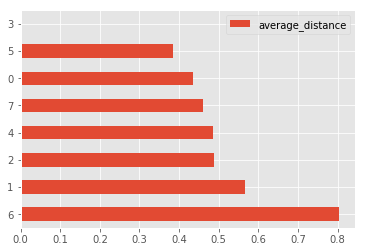

In [123]:
df_race[['group','average_distance']].plot.barh()

### Get average distance by poverty status

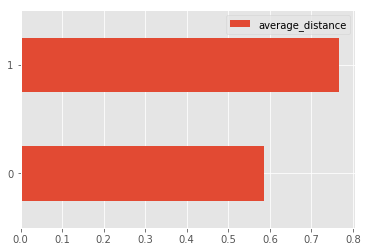

In [116]:
df_pov = pd.DataFrame()
df_pov['group'] = ['Below 25%', 'At or above 25%']
df_pov['average_distance'] = [df[df['pct_poverty'] < .25]['dis_rating_above_6'].mean(), df[df['pct_poverty'] >= .25]['dis_rating_above_6'].mean()]

df_pov[['group','average_distance']].plot.barh()

### Slice by distance 

In [124]:
# What's the racial makeup of block groups above the median distance vs. below?
median_distance = df['dis_rating_above_6'].median()
df['distance_group'] = np.where(df['dis_rating_above_6'] > median_distance, 'above median', 'below median')

df_dis = pd.DataFrame()
df_dis['group'] = df['distance_group'].unique()
race_columns = df['majority_race'].unique()

for race in race_columns:
    df_dis['pop_' + race] = df_dis['group'].apply(lambda x: df[df['distance_group'] == x]['grade_1_5_' + race].sum())

df_dis

group  pop_white  pop_Hisp  pop_black  pop_two  pop_other  pop_asian
0  below median       3846      2691       5767      620       1330        364
1  above median       1700      1276      11175      432        671        203

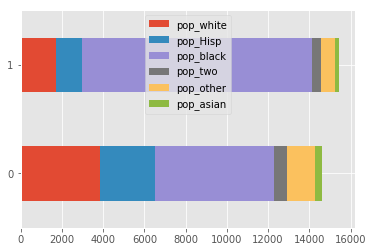

In [125]:
# Just for sketching -- would want to separate out Hispanic counts
df_dis.plot.barh(stacked=True)

### Export dataframe as csv

In [126]:
df.to_csv('data/school-distance-analysis.csv')